In [1]:
import anndata as ad
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import palantir
import pandas as pd
import os
from math import floor
from collections import Counter 
import mellon 
from sklearn.mixture import GaussianMixture
import re
import itertools as it
from sklearn import metrics
from copy import deepcopy
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
%matplotlib inline

import sys
sys.path.append(os.getcwd())

from GLOBAL_VARIABLES.GLOBAL_VARIABLES import cc_mapping_package_dir, pdac_data_dir
sys.path.append(cc_mapping_package_dir)

from cc_mapping import pseudotime, utils, preprocess, core, plot

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:
phase_color_mapping_dict = {'G0':'turquoise',
                            'G1':'orange',
                            'G2':'dodgerblue',
                            'M':'red',
                            'S':'orchid',
                            'nan':'lightgrey',
                            'G0/G1': 'white',
                            'G2/M': 'white',}

#define which features will be used to distinguish between the different cell cycle phases
cc_phase_gene_dict = {'G0/G1': 'Int_Med_pRB_nuc',
                      'G0/G1, S, G2/M': 'Int_Intg_DNA_nuc',
                      'G2/M': 'Int_Med_pp21_nuc',
}

#additional arguments for the GMM
GMM_kwargs = {'init_params': 'k-means++', 'n_init':10, 'max_iter':1000}

In [3]:
cell_line = 'HPAC'

pdac_data_dir = pdac_data_dir
data_dir = f'{pdac_data_dir}/{cell_line}'

filename = f'{cell_line}_RMM_FK_ALL_DK_DIP.h5ad'

data_file = os.path.join(data_dir, filename)

adata = ad.read_h5ad(data_file)

In [4]:
########## G0/G1,S,M/G2 ##########
DNA_gene = cc_phase_gene_dict['G0/G1, S, G2/M']
DNA_x = adata[:, DNA_gene].X.copy()

n_components = 3
DNA_GMM_dict = core.fit_GMM(DNA_x, n_components=n_components)

DNA_data_probs = DNA_GMM_dict['data_probs']

argsort_DNA_data_probs = np.argmax(DNA_data_probs, axis=1)

DNA_phase_mapping_dict = {0: 'G0/G1',1:  'S',2: 'G2/M'}
adata.obs['GMM_phase'] = [DNA_phase_mapping_dict[arg_idx] for arg_idx in argsort_DNA_data_probs]

adata.obs['GMM_phase_colors'] = [phase_color_mapping_dict[phase] for phase in adata.obs['GMM_phase']]


Text(0.5, 1.0, 'Int_Intg_DNA_nuc')

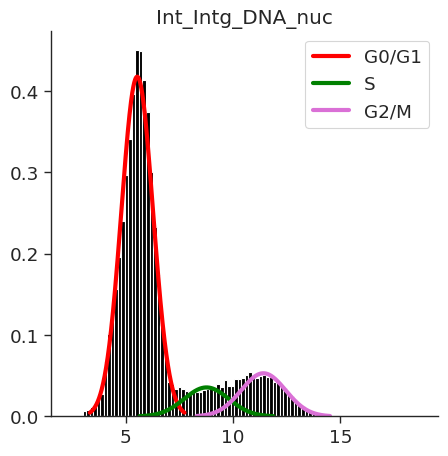

In [5]:
DNA_GMM_dict['labels'] = ['G0/G1', 'S', 'G2/M']
DNA_GMM_dict['colors'] = ['red', 'green', 'orchid']

plot.plot_GMM(DNA_x, DNA_GMM_dict, num_std=3, plot_all=True)
plt.title(DNA_gene)

In [6]:
########## G0/G1 ##########
G0_G1_gene = cc_phase_gene_dict['G0/G1']

G0_G1_adata = preprocess.row_data_partitioning(adata, 'G0/G1', 'GMM_phase')

pRB_x = G0_G1_adata[:, G0_G1_gene].X.copy()
kwargs = {'init_params': 'k-means++', 'n_init':10, 'max_iter':1000}

n_components = 2
pRB_phase_mapping_dict = {0: 'G0',1:  'G1'}

pRB_GMM_dict = core.fit_GMM(pRB_x, n_components=n_components,kwargs=kwargs)

pRB_data_probs = pRB_GMM_dict['data_probs']

adata = core.generate_GMM_labels(adata,
                                G0_G1_adata,
                                pRB_data_probs,
                                pRB_phase_mapping_dict,
                                phase_color_mapping_dict,
                                obs_label='GMM_phase')

Text(0.5, 1.0, 'Int_Med_pRB_nuc')

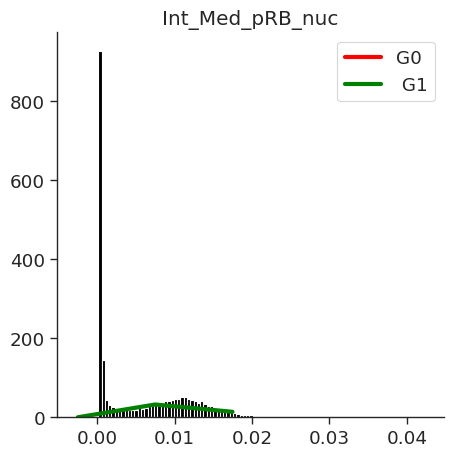

In [8]:
pRB_GMM_dict['labels'] = ['G0', ' G1']
pRB_GMM_dict['colors'] = ['red', 'green']

plot.plot_GMM(pRB_x, pRB_GMM_dict, num_std=3, plot_all=True)
plt.title(G0_G1_gene)

In [9]:
########## G2/M ##########

G2M_gene = cc_phase_gene_dict['G2/M']

G2M_adata = preprocess.row_data_partitioning(adata, 'G2/M', 'GMM_phase')

n_components = 2
pp21_x = G2M_adata[:, G2M_gene].X.copy()

kwargs = {'init_params': 'k-means++', 'n_init':10, 'max_iter':1000}
pp21_GMM_dict = core.fit_GMM(pp21_x, n_components=n_components,kwargs=kwargs)

pp21_data_probs = pp21_GMM_dict['data_probs']

pp21_phase_mapping_dict = {0: 'G2',1:  'M'}
adata = core.generate_GMM_labels(adata,
                                G2M_adata,
                                pp21_data_probs,
                                pp21_phase_mapping_dict,
                                phase_color_mapping_dict,
                                obs_label='GMM_phase')


Text(0.5, 1.0, 'Int_Med_pp21_nuc')

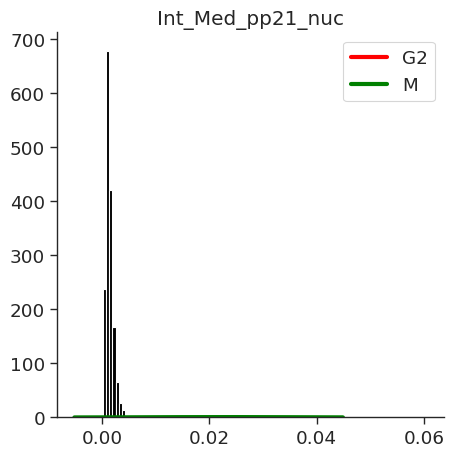

In [10]:
pp21_GMM_dict['labels'] = ['G2', 'M']
pp21_GMM_dict['colors'] = ['red', 'green']

plot.plot_GMM(pp21_x, pp21_GMM_dict, num_std=2, plot_all=True)
plt.title(G2M_gene)

# Additional Dianogistic Tools

In [11]:
adata.obs['G0/G1 data probs'] = DNA_data_probs[:,0]
adata.obs['S data probs'] = DNA_data_probs[:,1]
adata.obs['G2/M data probs'] = DNA_data_probs[:,2]

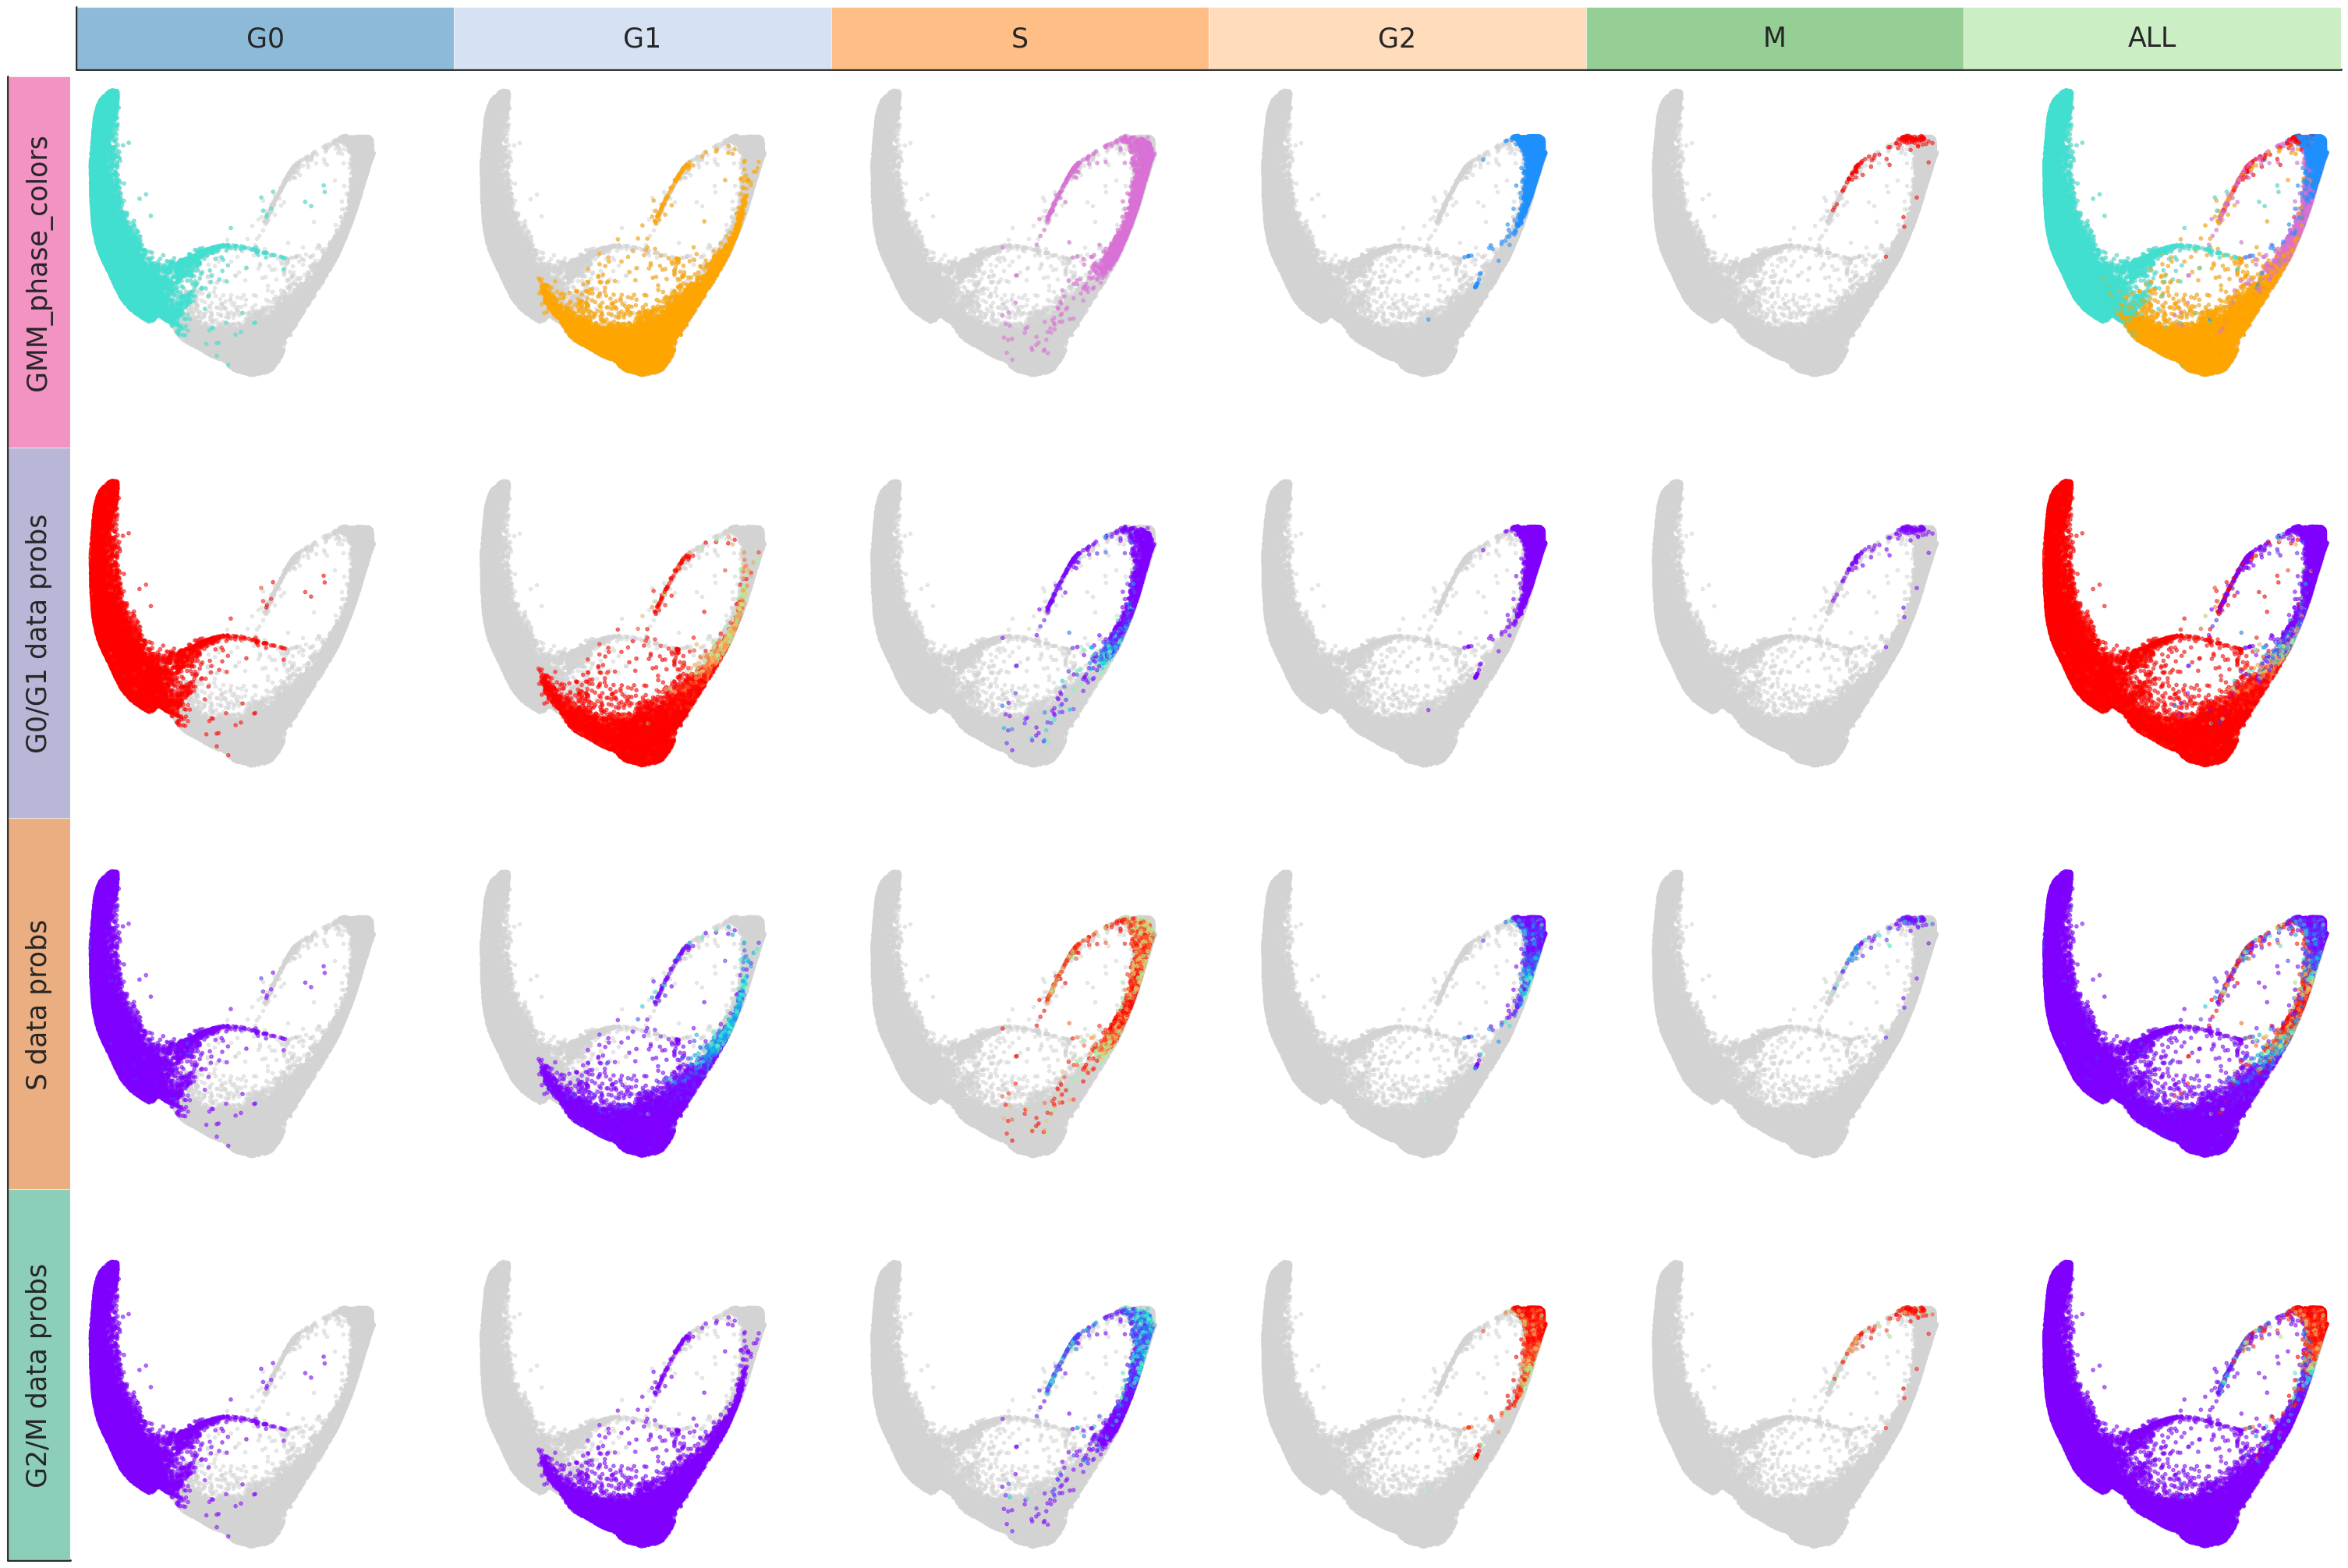

In [12]:
color_info_dict = {'GMM_phase_colors': {'color_type': 'catergorical'},
                'G0/G1 data probs': {'color_type': 'continuous_obs'},
                'S data probs': {'color_type': 'continuous_obs'},
                'G2/M data probs': {'color_type': 'continuous_obs'},
                }

kwargs = {'s': 10,
            'alpha': 0.5,
            'rasterized': True,
        }

plot.plot_row_partitions(adata, 'GMM_phase', 
                         color_info_dict=color_info_dict,
                         unit_size=5,
                         column_labels=['G0', 'G1', 'S', 'G2', 'M', 'ALL'],
                         kwargs=kwargs)

Text(0.5, 1.0, 'Int_Med_pRB_nuc')

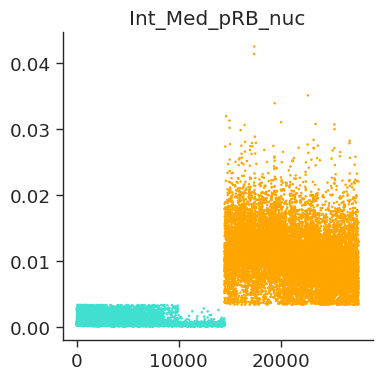

In [13]:
gene = G0_G1_gene

GMM_G0_G1_adata = preprocess.row_data_partitioning(adata, ['G0','G1'], 'GMM_phase')

x = np.arange(GMM_G0_G1_adata.shape[0])
y = GMM_G0_G1_adata[:, gene].X.copy()

GMM_phase_colors = GMM_G0_G1_adata.obs['GMM_phase_colors']

plt.scatter(x,y, c=GMM_phase_colors, s=1)
plt.title(gene)

## Finds "optimal" number of guassian mixture components. Just a sanity check

In [14]:
gene = G0_G1_gene
cc_x = adata[:, gene].X.copy()

bics = []
min_bic = 0
counter=1
for i in range (20): # test the AIC/BIC metric between 1 and 10 components
  gmm = GaussianMixture(n_components = counter, max_iter=1000, random_state=0, covariance_type = 'full')
  labels = gmm.fit(cc_x).predict(cc_x)
  bic = gmm.bic(cc_x)
  bics.append(bic)
  if bic < min_bic or min_bic == 0:
    min_bic = bic
    opt_bic = counter
  counter = counter + 1

Text(0.5, 1.0, 'Opt. components = 6')

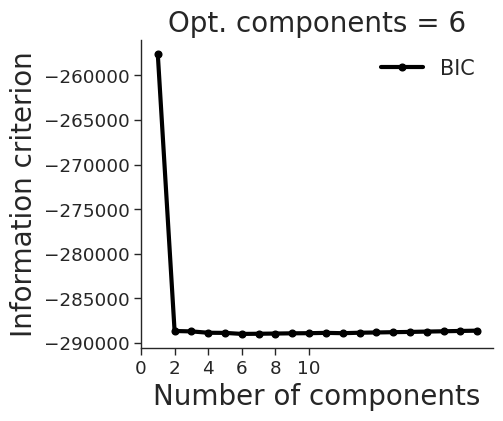

In [15]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1,2,1)
# Plot 1
plt.plot(np.arange(1,21), bics, 'o-', lw=3, c='black', label='BIC')
plt.legend(frameon=False, fontsize=15)
plt.xlabel('Number of components', fontsize=20)
plt.ylabel('Information criterion', fontsize=20)
plt.xticks(np.arange(0,11, 2))
plt.title('Opt. components = '+str(opt_bic), fontsize=20)